# CMS OpenData QCD Jets - Machine learning 


importing the basic libraries such as numpy, pandas and matplotlib

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import uproot

# Load a ROOT file
filePath='JetNtuple_RunIISummer16_13TeV_MC_1.root'
rootFile = uproot.open(filePath)['AK4jets']['jetTree']

# Create and fill a dataframe    
df = rootFile.arrays(library="pd")

## Quark/gluon jet classification

The machine learning example we present here is the classification of jets originating either from gluons or the three of the lightest quarks (_up_, _down_ and _strange_). This is an important task, since on the observable macroscopic level the two types of jets look very similar, but from a physical point of view the difference between them is significant.

Jets are present in practically every interesting high energy proton-proton collision event. Protons themselves are composite particles made up of three quarks (two _up_ quarks and one _down_ quark), which are bound together by gluons. These color-charged quarks and gluons are collectively known as partons. Quantum chromodynamics (QCD) is the theory of strong interaction and describes how color-charged particles behave. As the protons collide, the transfer of momentum causes the interacting partons to accelerate in directions perpendicular to the colliding proton beams. The accelerating partons radiate gluons, which can split into quark-antiquark pairs or radiate even more gluons. This chain reaction produces a shower of partons and they eventually form observable hadrons in a cone-shaped cascade, called a jet. The partons can interact in various interesting ways in the proton-proton collision and to understand these interaction processes, we need to be able to accurately classify the observed jets.

Since only the hadron-level information of a jet is available to us, we must infer the initiating parton of a jet from certain observable properties. Traditionally in the CMS collaboration, the task of identifying quark and gluon jets has been done by building a likelihood-based discriminator from three theoretically-motivated variables (see the public physics analysis summary _CMS-PAS-JME-13-002_ for more detailed information).

Let's have a look at these three variables by plotting histograms.


In [3]:
# First remove all the other types of jets from the data except the gluon and the light quark (UDS) jets
df = df[(df.isPhysG==1) | (df.isPhysUDS==1)].reset_index()

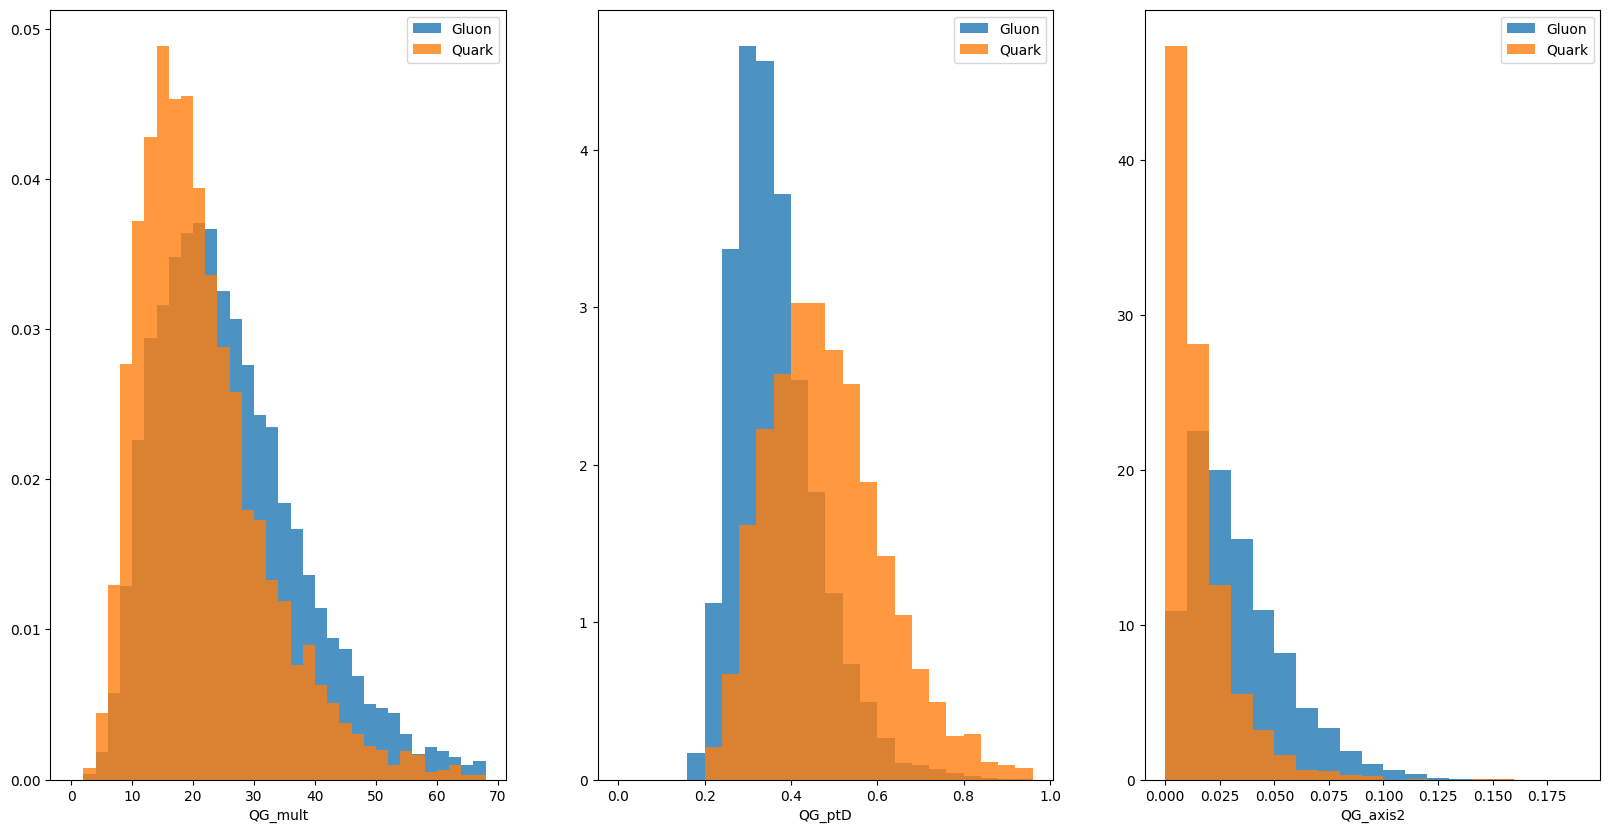

In [4]:
hist_columns = ['QG_mult','QG_ptD','QG_axis2']
binnings = [np.arange(0,70,2), np.arange(0.0,1.0,0.04), np.arange(0.0,0.2,0.01)]
ind = 0
fig, axes = plt.subplots(1, 3, figsize=(20,10))

for column in hist_columns:
    axes[ind].hist( df[df.isPhysG==1][column], bins=binnings[ind], alpha=0.8, label='Gluon', density=1 )
    axes[ind].hist( df[df.isPhysUDS==1][column], bins=binnings[ind], alpha=0.8, label='Quark', density=1 )
    axes[ind].set_xlabel(column)
    axes[ind].legend()
    ind = ind+1

From left to right these variables are the __jet multiplicity (QG_mult)__, the __jet momentum distribution variable (QG_ptD)__ and the __jet minor axis (QG_axis2)__. The distributions display statistical differences between the two types of jets.

__Jet multiplicity__ is the number of particles contained in the jet (subject to certain constraints on the properties of the particles, see _CMS-PAS-JME-13-002_ again). Gluons are expected to radiate more intensely, so on average gluon jets contain more particles.

The __jet momentum distribution variable__ is defined as $p_T D = \frac{\sqrt{\sum_i p_{T,i}^2}}{\sum_i p_{T,i}}$, where $p_{T,i}$ is the transverse momentum of a particle and the sum _i_ is over the jet's constituents. It describes how the total transverse momentum of a jet is distributed to its constituents. Quark jets are expected to have fewer constituents carrying the majority of the jet's momentum, which means that the value of $p_T D$ is on average larger for quark jets.

The __jet minor axis__ (often also denoted by $\sigma_2$) describes the width of the jet when it is approximated as an ellipse. Gluon jets are on average wider than quark jets.

In the CMS collaboration, the traditional quark/gluon jet classifier, or discriminator, is based on these three variables. The likelihood-product discriminator is a very simple approach, but also relatively robust and reliable. It assigns a value between zero and one as the probability of a jet originating from a light quark. This value is also contained in the data set for each jet in the __jetQGl__ column. Let's see how it looks.

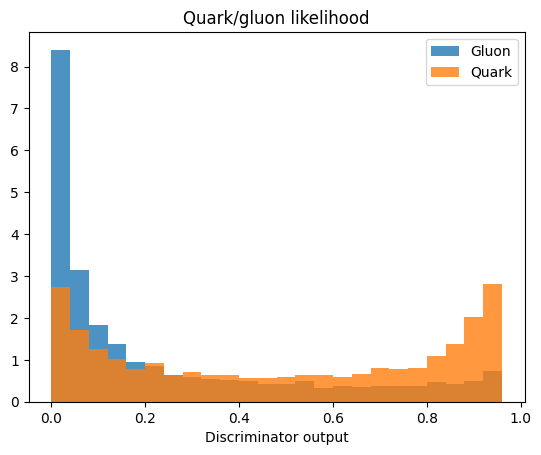

In [5]:
plt.clf()
binning = np.arange(0.0, 1.0, 0.04)
plt.hist( df[df.isPhysG==1]['jetQGl'], bins=binning, alpha=0.8, label='Gluon', density=1 )
plt.hist( df[df.isPhysUDS==1]['jetQGl'], bins=binning, alpha=0.8, label='Quark', density=1 )
plt.legend()
plt.xlabel('Discriminator output')
plt.title('Quark/gluon likelihood');

As can be seen, the discriminator can certainly be improved. In the case of a perfect discriminator, the output for all the gluon jets would be zero and for all the quark jets it would one. One characteristic problem of the likelihood-based approach is the assumption that the variables are uncorrelated. In this case they are not, so let's try to improve upon the discriminator by utilizing deep learning methods.

## Training a simple DNN classifier

Let's start by randomly dividing the data set into training and test sets. Our target output for the deep neural network is the __isPhysUDS__ column, the value of which is one for light quark jets and zero for gluon jets. Hence the output will be similar to the likelihood discriminator, allowing us to directly compare their performance. 

In [6]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)

train_y = train.isPhysUDS
test_y = test.isPhysUDS

Next we choose the input features for the neural network. In addition to the aforementioned three variables, let's add the transverse momentum of the jet (__jetPT__) and the pseudorapidity of the jet (__jetEta__). The pseudorapidity is related to the polar angle of the jet's direction in the cylindrical coordinate system of the CMS detector.

We will also perform some basic preprocessing in the form of normalizing the input features by columnwise subtraction of the mean and division by the standard deviation.

In [7]:
input_features = ['jetPt', 'jetEta', 'QG_mult', 'QG_ptD', 'QG_axis2']

train_x = train[input_features]
test_x = test[input_features]

# Normalize the features
train_x_mean = train_x.mean()
train_x_std = train_x.std()

train_x = (train_x - train_x_mean) / train_x_std
test_x = (test_x - train_x_mean) / train_x_std

We are ready to build and train our neural network model. (Here I have made a few modifications to the code to run the example code using Tensorflow v1.x instead of the updated v2.x, the sessions funtionality has been removed hence we also supress the tensorflow from using v2.x methods the corresponing keras api that is built on the Tensorflow v1.x is accessed using a compatibility module.)(I have also increased the number of epochs from 10 to 100)

In [8]:

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import keras.backend as K
sess = tf.Session()
tf.compat.v1.keras.backend.set_session(sess)

from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout
from sklearn.utils import class_weight

# Define the DNN architecture
model = Sequential()
model.add(Dense(100, kernel_initializer='normal', activation='relu', input_dim=train_x.shape[1]))
model.add(Dropout(0.2))
model.add(Dense(100, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
model.compile(optimizer='Nadam', loss='binary_crossentropy', metrics=['accuracy'])

# Weight the training samples so that there is equal weight on gluon and quark jets
# even if there are different amount of them in the training set
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_y), y=train_y[:])

# Train the model
model.fit(train_x,
          train_y,
          epochs=100,
          batch_size=128,
          class_weight=class_weights,
          validation_split=0.2,
          shuffle=True,
          verbose=1);

Instructions for updating:
non-resource variables are not supported in the long term
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 8903 samples, validate on 2226 samples
Epoch 1/100
8903/8903 [==============================] - 0s 41us/sample - loss: 0.5679 - acc: 0.7426 - val_loss: 0.5017 - val_acc: 0.7579
Epoch 2/100
6656/8903 [=====================>........] - ETA: 0s - loss: 0.5082 - acc: 0.7593

d:\Physics Applications\Python\lib\site-packages\keras\src\engine\training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


8903/8903 [==============================] - 0s 17us/sample - loss: 0.5109 - acc: 0.7569 - val_loss: 0.4932 - val_acc: 0.7637
Epoch 3/100
8903/8903 [==============================] - 0s 18us/sample - loss: 0.5025 - acc: 0.7629 - val_loss: 0.4929 - val_acc: 0.7624
Epoch 4/100
8903/8903 [==============================] - 0s 17us/sample - loss: 0.5025 - acc: 0.7577 - val_loss: 0.4890 - val_acc: 0.7677
Epoch 5/100
8903/8903 [==============================] - 0s 17us/sample - loss: 0.5029 - acc: 0.7569 - val_loss: 0.4900 - val_acc: 0.7646
Epoch 6/100
8903/8903 [==============================] - 0s 17us/sample - loss: 0.5002 - acc: 0.7594 - val_loss: 0.4873 - val_acc: 0.7633
Epoch 7/100
8903/8903 [==============================] - 0s 18us/sample - loss: 0.4999 - acc: 0.7620 - val_loss: 0.4883 - val_acc: 0.7637
Epoch 8/100
8903/8903 [==============================] - 0s 16us/sample - loss: 0.4993 - acc: 0.7599 - val_loss: 0.4876 - val_acc: 0.7664
Epoch 9/100
8903/8903 [=======================

Let's see how the trained model performs by first creating predictions for the test set and plotting the classifier output.

d:\Physics Applications\Python\lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


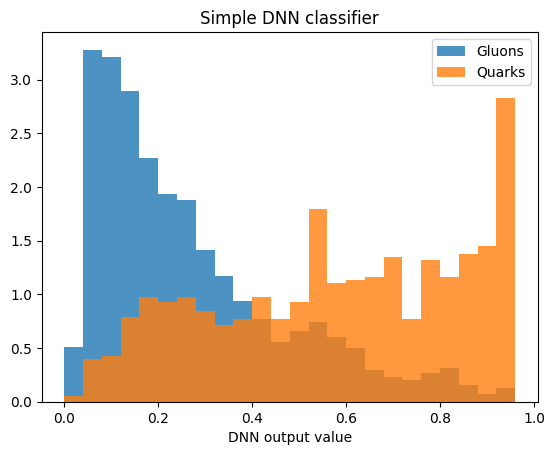

In [9]:
pred_y = model.predict(test_x)

plt.clf()
binning = np.arange(0.0, 1.0, 0.04)
plt.hist( pred_y[test_y==0], bins=binning, alpha=0.8, label="Gluons", density=1 )
plt.hist( pred_y[test_y==1], bins=binning, alpha=0.8, label="Quarks", density=1 )
plt.legend()
plt.xlabel('DNN output value')
plt.title('Simple DNN classifier');

In order to fairly compare our newly trained model and the traditional likelihood discriminator, we should look at the corresponding receiver operating characteristic (ROC) curves. The larger the area under the curve (AUC), the better the performance of the classifier.

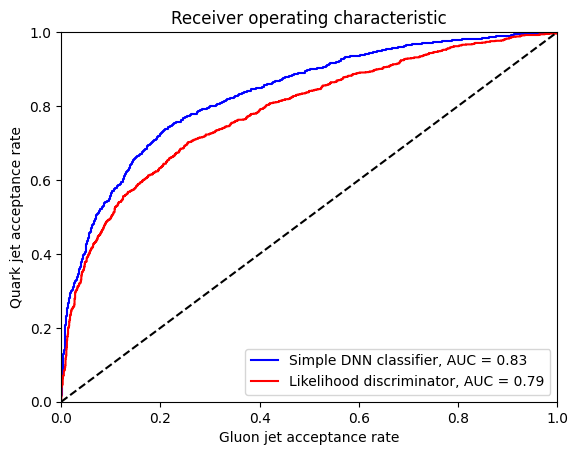

In [10]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fpr_dnn, tpr_dnn, thresholds_dnn  = roc_curve(test_y, pred_y)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

fpr_qgl, tpr_qgl, thresholds_qgl = roc_curve(test_y, test.jetQGl)
roc_auc_qgl = auc(fpr_qgl, tpr_qgl)

plt.clf()
plt.plot(fpr_dnn, tpr_dnn, 'b', label='Simple DNN classifier, AUC = %0.2f'% roc_auc_dnn)
plt.plot(fpr_qgl, tpr_qgl, 'r', label='Likelihood discriminator, AUC = %0.2f'% roc_auc_qgl)
plt.plot([0,1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc = 'lower right')
plt.title("Receiver operating characteristic")
plt.ylabel('Quark jet acceptance rate')
plt.xlabel('Gluon jet acceptance rate');

With higher ROC AUC value, we find that our newly trained classifier is better at the task in comparison to the likelihood discriminator.

This notebook provided just a quick introduction on the matter with a very simple neural network model using only a small portion of the full CMS OpenData QCD jet data set. The true strength of utilizing deep neural networks for this task was not demonstrated here, as it lies in the neural networks' ability of finding more subtle differences between the two types of jets in lower level features. Hence, by incorporating more information on e.g. the particle-level, we could build an even better DNN jet classifier. All in all, the field of jet physics is rife with exciting opportunities for machine learning applications, and the classification task presented here is just one of them. 